In [1]:
!pip install xgboost==1.0.2 

In [2]:
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def PlotCM(model,x_test,y_test):
  fig, ax = plt.subplots(1, 1)
  disp = plot_confusion_matrix(
      model, x_test, y_test,
      normalize=None, 
      display_labels=['No AKI', 'AKI'], 
      values_format='.0f', 
      ax=ax)

# Xgboost Model

In [3]:
data = pd.read_csv('MIMIC_Xgboost_Input.csv')
data = data.fillna(-10000)

In [4]:
data

,icustay_id,age,weight,gender,creatinine_seq_0,creatinine_seq_1,creatinine_seq_2,creatinine_seq_3,creatinine_seq_4,creatinine_seq_5,intake_seq_0,intake_seq_1,intake_seq_2,intake_seq_3,intake_seq_4,intake_seq_5,urine_seq_0,urine_seq_1,urine_seq_2,urine_seq_3,urine_seq_4,urine_seq_5,pH_seq_0,pH_seq_1,pH_seq_2,pH_seq_3,pH_seq_4,pH_seq_5,Hct_seq_0,Hct_seq_1,Hct_seq_2,Hct_seq_3,Hct_seq_4,Hct_seq_5,Bun_seq_0,Bun_seq_1,Bun_seq_2,Bun_seq_3,Bun_seq_4,Bun_seq_5,...,Na_seq_3,Na_seq_4,Na_seq_5,K_seq_0,K_seq_1,K_seq_2,K_seq_3,K_seq_4,K_seq_5,TP_seq_0,TP_seq_1,TP_seq_2,TP_seq_3,TP_seq_4,TP_seq_5,systolicBP_seq_0,systolicBP_seq_1,systolicBP_seq_2,systolicBP_seq_3,systolicBP_seq_4,systolicBP_seq_5,meanBP_seq_0,meanBP_seq_1,meanBP_seq_2,meanBP_seq_3,meanBP_seq_4,meanBP_seq_5,MSI_seq_0,MSI_seq_1,MSI_seq_2,MSI_seq_3,MSI_seq_4,MSI_seq_5,eGFR_seq_0,eGFR_seq_1,eGFR_seq_2,eGFR_seq_3,eGFR_seq_4,eGFR_seq_5,aki
0,200006,54.0723,82.4,1,1.1,1.1,1.1,1.1,1.1,1.1,0.000000,0.000000,0.000000,2000.000000,0.000000,60.000000,0.0,0.0,0.0,1000.0,300.0,115.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,35.9,35.9,35.9,35.9,35.9,35.9,13.0,13.0,13.0,13.0,13.0,13.0,...,135.0,135.0,135.0,4.2,4.2,4.2,4.1,4.1,4.1,36.166698,36.166698,36.166698,36.166698,37.388901,37.388901,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,75.664715,75.664715,75.664715,75.664715,75.664715,75.664715,1
1,200009,47.5560,87.2,0,0.5,0.5,0.5,0.5,0.5,0.5,0.000000,0.000000,4307.500000,1510.000000,1965.000000,1020.000000,0.0,0.0,720.0,400.0,275.0,75.0,7.46,7.51,7.39,7.41,7.29,7.32,37.0,26.0,30.3,31.0,30.7,27.0,15.0,15.0,15.0,16.0,16.0,16.0,...,143.0,143.0,138.0,3.9,5.6,4.1,3.9,3.9,4.4,35.099998,35.099998,37.299999,38.000000,38.099998,38.299999,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,115.174697,115.174697,115.174697,115.174697,115.174697,115.174697,1
2,200019,82.8831,65.0,0,1.1,1.0,1.0,1.0,1.0,1.0,0.000000,1100.000000,450.000000,490.000000,457.777000,431.512001,0.0,500.0,240.0,114.0,150.0,90.0,7.36,7.36,7.36,7.36,7.36,7.36,39.6,33.0,33.0,33.0,33.0,33.0,30.0,24.0,24.0,24.0,24.0,24.0,...,140.0,140.0,140.0,5.3,5.8,5.8,4.8,4.4,4.4,35.555599,37.555599,38.277802,38.777802,37.500000,36.722198,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,46.578610,52.267326,52.267326,52.267326,52.267326,52.267326,1
3,200025,49.4313,140.4,1,0.8,0.8,0.8,0.8,0.8,0.8,0.000000,0.000000,5357.008400,1687.341271,879.000000,439.000000,0.0,0.0,300.0,540.0,370.0,225.0,7.40,7.40,7.37,7.42,7.43,7.43,36.0,27.0,25.3,25.4,24.8,24.8,19.0,19.0,19.0,19.0,19.0,19.0,...,137.0,137.0,137.0,5.2,5.5,4.1,4.7,4.7,4.7,37.099998,37.099998,37.400002,38.299999,38.700001,38.700001,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,104.577965,104.577965,104.577965,104.577965,104.577965,104.577965,1
4,200028,64.8677,84.0,1,1.1,1.1,1.1,1.1,1.1,1.1,1503.774263,916.502382,73.161346,663.598815,425.879222,634.000012,208.0,160.0,200.0,265.0,345.0,210.0,7.33,7.33,7.35,7.37,7.43,7.43,29.3,27.3,27.3,26.5,26.5,26.5,14.0,14.0,14.0,14.0,14.0,14.0,...,137.0,137.0,137.0,4.1,4.1,4.1,3.2,3.2,3.2,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,1.312500,1.723404,1.543860,2.020833,1.696429,1.587302,70.138959,70.138959,70.138959,70.138959,70.138959,70.138959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split

X_train=data.drop(columns=['icustay_id','aki'])
Y_train=data['aki']
np.random.seed(100)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 1)

# Classification_Report, Confusion_Matrix, Feature_Importance

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      5245
           1       0.88      0.85      0.87      6905

    accuracy                           0.85     12150
   macro avg       0.85      0.85      0.85     12150
weighted avg       0.85      0.85      0.85     12150



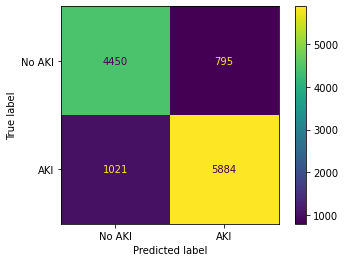

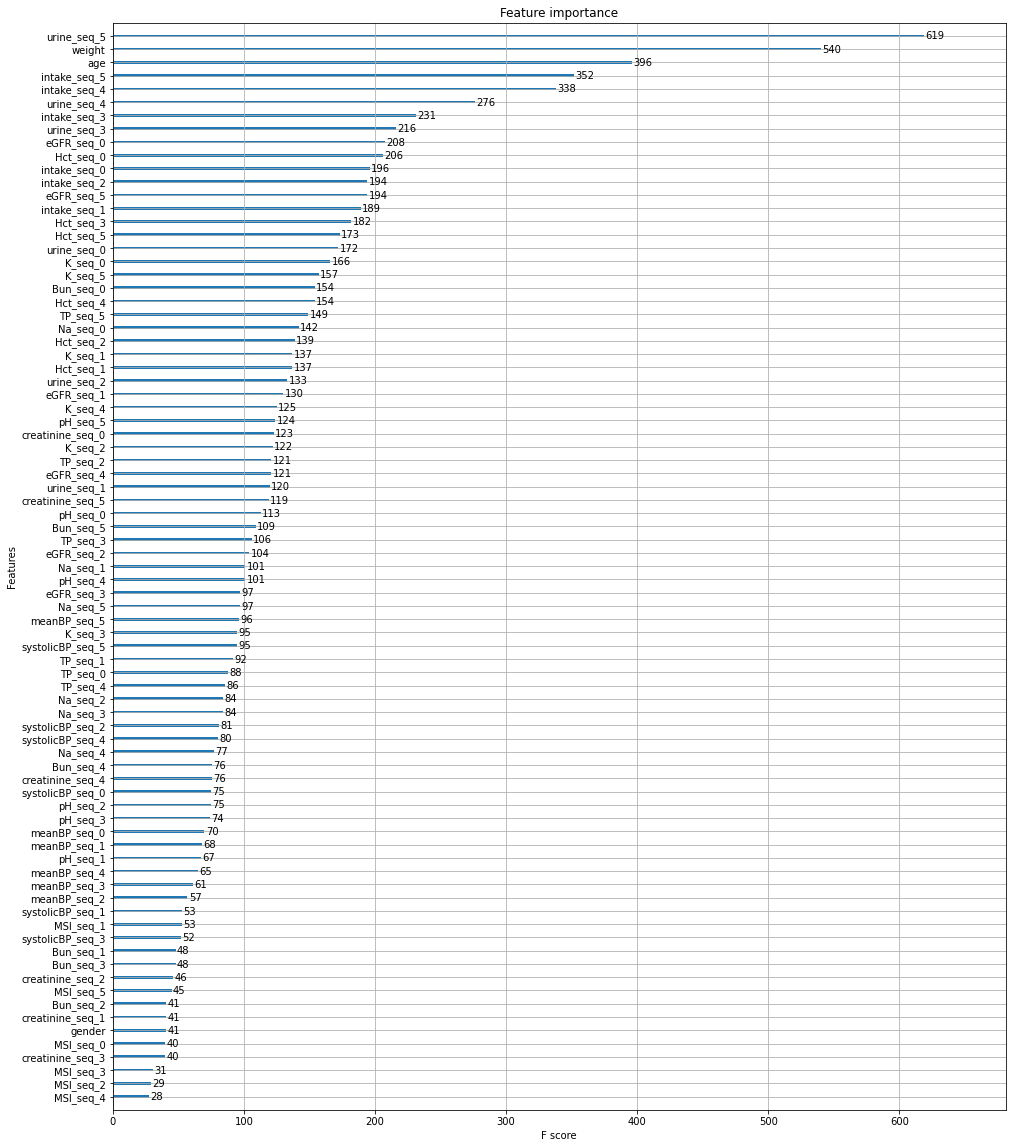

In [6]:
model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=400,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
cr = classification_report(y_test, y_predict)
print(cr)

PlotCM(model,x_test,y_test)

tryit = plot_importance(model)
tryit.figure.set_size_inches((16,20))


# Cross Validation

In [7]:
# 使用 5-fold cross validation，輸出平均準確度
k_fold = KFold(n_splits=5, shuffle=True, random_state=27)
cv_score = cross_val_score(model, X_train, Y_train, cv=k_fold, n_jobs=1, scoring='accuracy')
print('mean accuracy(5-fold cross validation):'+str(cv_score.mean()))

mean accuracy(5-fold cross validation):0.8516781053784175


# ROC curve

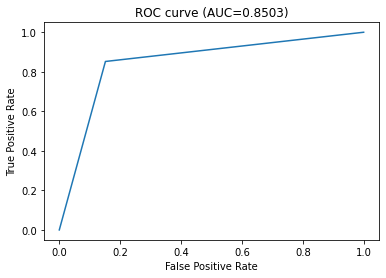

In [8]:
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve
Xgbc_auc=roc_auc_score(y_test,y_predict)

Xgbc_fpr,Xgbc_tpr,Xgbc_threasholds=roc_curve(y_test,y_predict) # 計算ROC的值,svm_threasholds為閾值
plt.title("ROC curve (AUC=%.4f)" %(Xgbc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(Xgbc_fpr,Xgbc_tpr)
plt.show()

# External Validation

In [9]:
external_data = pd.read_csv('EICU_Xgboost_Input.csv')
external_data = external_data.fillna(-10000)

In [10]:
external_data

,patientunitstayid,age,weight,gender,creatinine_seq_0,creatinine_seq_1,creatinine_seq_2,creatinine_seq_3,creatinine_seq_4,creatinine_seq_5,intake_seq_0,intake_seq_1,intake_seq_2,intake_seq_3,intake_seq_4,intake_seq_5,urine_seq_0,urine_seq_1,urine_seq_2,urine_seq_3,urine_seq_4,urine_seq_5,pH_seq_0,pH_seq_1,pH_seq_2,pH_seq_3,pH_seq_4,pH_seq_5,Hct_seq_0,Hct_seq_1,Hct_seq_2,Hct_seq_3,Hct_seq_4,Hct_seq_5,Bun_seq_0,Bun_seq_1,Bun_seq_2,Bun_seq_3,Bun_seq_4,Bun_seq_5,...,Na_seq_3,Na_seq_4,Na_seq_5,K_seq_0,K_seq_1,K_seq_2,K_seq_3,K_seq_4,K_seq_5,TP_seq_0,TP_seq_1,TP_seq_2,TP_seq_3,TP_seq_4,TP_seq_5,systolicBP_seq_0,systolicBP_seq_1,systolicBP_seq_2,systolicBP_seq_3,systolicBP_seq_4,systolicBP_seq_5,meanBP_seq_0,meanBP_seq_1,meanBP_seq_2,meanBP_seq_3,meanBP_seq_4,meanBP_seq_5,MSI_seq_0,MSI_seq_1,MSI_seq_2,MSI_seq_3,MSI_seq_4,MSI_seq_5,eGFR_seq_0,eGFR_seq_1,eGFR_seq_2,eGFR_seq_3,eGFR_seq_4,eGFR_seq_5,aki
0,141266,73.0,120.4,1,1.90,1.90,1.90,1.90,1.90,1.90,0.0,0.0,0.0,0.0,0.0,238.22,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,7.18,7.18,7.18,7.36,7.36,7.36,33.4,33.4,33.4,33.4,33.4,33.4,29.0,29.0,29.0,29.0,29.0,29.0,...,135.0,135.0,135.0,5.2,5.2,5.2,5.2,5.2,5.2,36.3,36.3,36.3,36.2,36.2,36.2,101.0,101.0,101.0,101.0,101.0,101.0,78.0,78.0,78.0,78.0,78.0,78.0,1.037037,1.037037,1.113402,1.189873,1.210526,1.230769,34.212148,34.212148,34.212148,34.212148,34.212148,34.212148,1
1,141304,70.0,-10000.0,1,2.34,2.34,2.34,2.34,2.34,2.05,0.0,0.0,0.0,0.0,0.0,1503.00,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,7.32,7.32,7.32,7.32,7.32,7.32,28.8,28.8,28.8,28.8,28.8,25.5,41.0,41.0,41.0,41.0,41.0,48.0,...,141.0,141.0,140.0,4.8,4.8,4.8,4.8,4.8,5.8,36.8,36.8,36.8,36.8,38.5,38.0,106.0,106.0,106.0,106.0,106.0,135.0,82.0,82.0,82.0,82.0,82.0,114.0,1.218750,1.218750,1.218750,1.218750,1.547945,1.966667,27.162124,27.162124,27.162124,27.162124,27.162124,31.873906,1
2,141314,45.0,-10000.0,1,1.67,1.67,1.67,1.67,1.67,1.67,0.0,0.0,0.0,0.0,0.0,350.00,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,7.14,7.14,7.14,7.14,7.14,7.31,34.1,34.1,34.1,34.1,34.1,34.1,13.0,13.0,13.0,13.0,13.0,13.0,...,158.0,158.0,158.0,8.0,8.0,8.0,8.0,8.0,8.0,35.5,35.5,35.5,35.5,35.5,35.5,53.0,53.0,53.0,53.0,53.0,156.0,47.0,47.0,47.0,47.0,47.0,96.0,2.272727,2.272727,2.272727,2.272727,2.272727,3.052632,48.679967,48.679967,48.679967,48.679967,48.679967,48.679967,1
3,141448,65.0,79.8,1,1.57,1.57,1.57,1.57,1.57,1.57,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.00,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,35.8,35.8,35.8,35.8,35.8,35.8,31.0,31.0,31.0,31.0,31.0,31.0,...,138.0,138.0,138.0,2.8,2.8,2.8,2.8,2.8,2.8,36.8,36.8,36.8,36.8,36.8,37.5,117.0,117.0,117.0,117.0,117.0,117.0,84.0,84.0,84.0,84.0,84.0,84.0,1.304348,1.304348,1.304348,1.304348,1.304348,1.446154,45.578159,45.578159,45.578159,45.578159,45.578159,45.578159,1
4,141470,58.0,-10000.0,0,2.44,2.44,2.44,2.44,2.44,2.44,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.00,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,42.8,42.8,42.8,42.8,42.8,42.8,33.0,33.0,33.0,33.0,33.0,33.0,...,131.0,131.0,131.0,4.3,4.3,4.3,4.3,4.3,4.3,36.7,36.7,36.7,36.7,36.7,38.2,94.0,94.0,94.0,94.0,94.0,94.0,70.0,70.0,70.0,70.0,70.0,70.0,1.468354,1.468354,1.468354,1.468354,1.468354,1.746269,21.173280,21.173280,21.173280,21.173280,21.173280,21.173280,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38791,3352884,85.0,62.6,0,0.88,0.88,0.88,0.88,0.88,0.88,0.0,0.0,0.0,0.0,0.0,84.38,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.0,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,-10000.00,37.0,37.0,37.0,37.0,30.0,30.0,20.0,20.0,20.0,20.0,

              precision    recall  f1-score   support

           0       0.63      0.82      0.71     19502
           1       0.74      0.50      0.60     19294

    accuracy                           0.66     38796
   macro avg       0.68      0.66      0.65     38796
weighted avg       0.68      0.66      0.65     38796



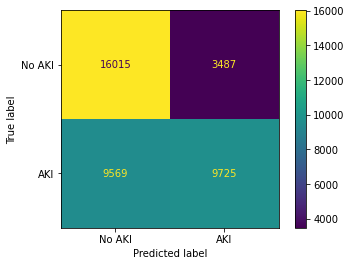

In [11]:
X_Val=external_data.drop(columns=['patientunitstayid','aki'])
Y_Val=external_data['aki']

y_predict = model.predict(X_Val)
cr = classification_report(Y_Val, y_predict)
print(cr)

PlotCM(model,X_Val,Y_Val)

